# Моделирование процессов старения с помощью данных метилирования генома человека

## Описание данных

Датасет с данными о метилировании ДНК GSE87571 в 476 366 сайтах распо по всему геному белых кровяных телец из когорты населения (N = 421) в возрасте от 14 до 94 лет, количество образцов составляет 732.

Адрес датасета на сайте GEO
https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE87571

In [1]:
from google.colab import drive

import os
import time
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import joblib

In [4]:
# Подключаемся к диску
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# укажем путь к корневой папке с данными
if os.path.isdir('/content/drive/Shareddrives/OpenLabData/Methylation/GSE87571/preprocessed'):
    
    path_root_dir = '/content/drive/Shareddrives/OpenLabData'
    path_main_dir = '/content/drive/Shareddrives/OpenLabData/Methylation/GSE87571'
else: 
    raise Exception('Задайте путь к корневой папке с файлами')

## Загрузка данных с уровнями метилирования в CG-islands

In [8]:
data_joined = pd.read_csv(
    path_main_dir + "/preprocessed/data_methylation.csv",
    index_col = 0
    )

display(data_joined.shape)
display(data_joined.head())
display(data_joined.tail())

(485512, 732)

,X1,X10,X100,X101,X102,X103,X104,X105,X106,X107,X108,X109,X11,X110,X111,X112,X113,X114,X115,X116,X117,X118,X119,X12,X120,X121,X122,X123,X124,X125,X126,X127,X128,X129,X13,X130,X131,X132,X133,X134,...,X722,X723,X724,X725,X726,X727,X728,X729,X73,X730,X731,X732,X74,X75,X76,X77,X78,X79,X8,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X9,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99
ID_REF,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
cg00050873,0.824023,NaN,NaN,NaN,NaN,0.858559,NaN,0.878558,NaN,NaN,0.838746,NaN,NaN,NaN,0.841664,0.805454,0.843796,0.796351,NaN,NaN,0.843360,0.858282,0.857744,NaN,0.837417,NaN,NaN,0.836796,NaN,NaN,0.873428,NaN,NaN,NaN,0.847360,0.862155,NaN,NaN,NaN,NaN,...,0.867005,0.931992,0.847727,NaN,0.859530,0.891878,0.883543,0.861838,0.879513,NaN,NaN,0.834908,NaN,0.861145,NaN,NaN,0.819572,NaN,0.868096,NaN,NaN,NaN,NaN,NaN,0.849218,NaN,0.846792,NaN,0.856054,NaN,NaN,NaN,0.877338,NaN,0.898305,0.829739,NaN,0.832990,NaN,0.852145
cg00212031,0.031579,NaN,NaN,NaN,NaN,0.073623,NaN,0.076204,NaN,NaN,0.036398,NaN,NaN,NaN,0.063607,0.162415,0.223210,0.130303,NaN,NaN,0.025841,0.038522,0.039403,NaN,0.036382,NaN,NaN,0.008998,NaN,NaN,0.035502,NaN,NaN,NaN,0.042006,0.030202,NaN,NaN,NaN,NaN,...,0.021552,0.034975,0.025621,NaN,0.040818,0.017671,0.046056,0.084678,0.134360,NaN,NaN,0.078292,NaN,0.015274,NaN,NaN,0.005870,NaN,0.025511,NaN,NaN,NaN,NaN,NaN,0.056729,NaN,0.045585,NaN,0.021491,NaN,NaN,NaN,NaN,NaN,NaN,0.072655,NaN,0.066660,NaN,0.045496
cg00213748,0.890866,NaN,NaN,NaN,NaN,0.752563,NaN,0.770042,NaN,NaN,0.852146,NaN,NaN,NaN,0.825187,0.918984,0.676990,0.771824,NaN,NaN,0.838243,0.870406,0.839106,NaN,0.730814,NaN,NaN,0.822684,NaN,NaN,0.881152,NaN,NaN,NaN,0.811610,0.723932,NaN,NaN,NaN,NaN,...,0.845409,0.900382,0.902650,NaN,0.702722,0.844169,0.839452,0.882290,0.775016,NaN,NaN,0.873085,NaN,0.808382,NaN,NaN,0.827652,NaN,0.887814,NaN,NaN,NaN,NaN,NaN,0.862404,NaN,0.864341,NaN,0.872800,NaN,NaN,NaN,NaN,NaN,NaN,0.829465,NaN,0.907471,NaN,0.777021
cg00214611,0.036628,NaN,NaN,NaN,NaN,0.027040,NaN,0.033889,NaN,NaN,0.019152,NaN,NaN,NaN,0.032050,0.015607,0.051450,0.042014,NaN,NaN,0.045477,0.029371,0.021428,NaN,0.034424,NaN,NaN,0.034759,NaN,NaN,0.025425,NaN,NaN,NaN,0.041822,0.028606,NaN,NaN,NaN,NaN,...,0.031124,0.007983,0.020527,NaN,0.013081,0.055336,0.066505,0.028319,0.026466,NaN,NaN,0.035841,NaN,0.019751,NaN,NaN,0.035901,NaN,0.049498,NaN,NaN,NaN,NaN,NaN,0.025291,NaN,0.014650,NaN,0.028407,NaN,NaN,NaN,NaN,NaN,NaN,0.039067,NaN,0.032361,NaN,0.012872
cg00455876,0.776977,NaN,NaN,NaN,NaN,0.792298,NaN,0.764299,NaN,NaN,0.699582,NaN,NaN,NaN,0.748545,0.775851,0.697964,0.685611,NaN,0.177022,0.703062,0.713536,0.749135,NaN,0.726898,NaN,NaN,0.763210,NaN,NaN,0.827820,NaN,NaN,NaN,0.800864,0.725977,NaN,NaN,NaN,NaN,...,0.836490,0.875024,0.790456,NaN,0.733832,0.754588,0.761895,0.776490,0.737094,NaN,NaN,0.723102,NaN,0.693403,NaN,NaN,0.687916,0.264434,0.838640,NaN,NaN,NaN,NaN,NaN,0.784422,NaN,0.764464,NaN,0.813226,NaN,NaN,NaN,0.575313,0.271422,0.549002,0.773916,NaN,0.736907,NaN,0.773452


,X1,X10,X100,X101,X102,X103,X104,X105,X106,X107,X108,X109,X11,X110,X111,X112,X113,X114,X115,X116,X117,X118,X119,X12,X120,X121,X122,X123,X124,X125,X126,X127,X128,X129,X13,X130,X131,X132,X133,X134,...,X722,X723,X724,X725,X726,X727,X728,X729,X73,X730,X731,X732,X74,X75,X76,X77,X78,X79,X8,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X9,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99
ID_REF,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ch.22.909671F,0.057891,0.221108,0.066405,0.076406,0.044699,0.037862,0.109330,0.067954,0.061868,0.096265,0.113245,0.085908,0.036939,0.068085,0.064652,0.067954,0.156592,0.095258,0.176304,0.092209,0.142686,0.078953,0.182068,0.097592,0.065104,0.067836,0.064842,0.076152,0.123869,0.107692,0.063390,0.063759,0.128741,0.154433,0.082205,0.094552,0.047939,0.150227,0.079537,0.071955,...,0.067071,0.158166,0.064856,0.141411,0.102136,0.091702,0.174574,0.122583,0.091240,0.083451,0.116304,0.057085,0.128586,0.086306,0.121760,0.073242,0.108521,0.194972,0.106434,0.082598,0.143298,0.049823,0.045832,0.055905,0.059737,0.140065,0.122270,0.070752,0.057453,0.148038,0.089063,0.072175,0.063639,0.057725,0.070572,0.115592,0.054574,0.096974,0.092796,0.088967
ch.22.46830341F,0.042315,0.034829,0.025640,0.043598,0.021270,0.034973,0.037485,0.026972,0.033317,0.034609,0.047204,0.034122,0.035166,0.041157,0.048457,0.034643,0.055755,0.069211,0.041657,0.021359,0.050363,0.030712,0.034971,0.033104,0.018720,0.033349,0.025996,0.023690,0.028847,0.043109,0.027124,0.031047,0.061259,0.043712,0.023715,0.054650,0.024355,0.062117,0.031990,0.034997,...,0.029372,0.020667,0.023968,0.031719,0.023081,0.032627,0.036993,0.038633,0.042294,0.035727,0.033440,0.025066,0.033645,0.031179,0.047717,0.027299,0.054274,0.059164,0.036584,0.057605,0.048947,0.050566,0.035505,0.038367,0.041294,0.029617,0.080971,0.032314,0.039087,0.062167,0.051173,0.053268,0.045207,0.042592,0.022912,0.031185,0.029953,0.034787,0.078034,0.053333
ch.22.1008279F,0.005898,0.006287,0.006652,0.013686,0.008111,0.014673,0.021664,0.010201,0.010480,0.031307,0.009866,0.050919,0.006549,0.008376,0.020937,0.009674,0.017101,0.011223,0.004275,0.004740,0.016785,0.009996,0.010474,0.016316,0.007015,0.013688,0.007119,0.007108,0.002883,0.018796,0.004846,0.002677,0.025106,0.010428,0.008338,0.008355,0.002386,0.016296,0.018681,0.009468,...,0.043917,0.002792,0.013400,0.004150,0.001749,0.003962,0.007486,0.000610,0.006327,0.010365,0.008120,0.005174,0.006983,0.010362,0.008525,0.010489,0.017359,0.013781,0.021892,0.001925,0.004793,0.007310,0.003121,0.006121,0.008843,0.003186,0.005019,0.003950,0.002250,0.010287,0.007581,0.012229,0.010151,0.008376,0.018441,0.008182,0.011095,0.003545,0.021802,0.017240
ch.22.47579720R,0.083398,0.112058,0.070752,0.095896,0.056537,0.091068,0.088590,0.072258,0.067755,0.090849,0.088480,0.038262,0.070006,0.076102,0.078687,0.073415,0.104516,0.082287,0.059058,0.055221,0.083165,0.077213,0.076119,0.066884,0.071297,0.046844,0.072102,0.075897,0.061559,0.099934,0.058988,0.078345,0.101370,0.076835,0.069254,0.103089,0.071740,0.103913,0.074640,0.048990,...,0.093651,0.047176,0.049426,0.075857,0.056473,0.062807,0.069708,0.080949,0.064581,0.075947,0.061484,0.086033,0.078289,0.062118,0.084522,0.072706,0.099645,0.086482,0.101655,0.099141,0.090713,0.096419,0.088357,0.059142,0.072492,0.070058,0.075602,0.089598,0.098309,0.087743,0.084822,0.115127,0.081492,0.097266,0.048890,0.080128,0.072277,0.070170,0.091591,0.086221
ch.22.48274842R,0.028080,0.035582,0.023578,0.025565,0.031796,0.032884,0.026750,0.023984,0.022573,0.035991,0.032297,0.122074,0.022120,0.022910,0.029090,0.164307,0.044079,0.034482,0.020546,0.025468,0.025563,0.031766,0.027424,0.028480,0.028656,0.031908,0.029915,0.020815,0.025947,0.035349,0.021210,0.023120,0.210506,0.030139,0.030743,0.055919,0.026922,0.048914,0.026912,0.040013,...,0.038064,0.027737,0.025562,0.037099,0.035906,0.029821,0.194078,0.025804,0.021485,0.029565,0.031361,0.030342,0.024849,0.024621,0.040375,0.026786,0.206001,0.043671,0.043690,0.030111,0.035336,0.029572,0.196473,

In [ ]:
# Загрузим значения вероятностей ошибки распознавания уровней метелирования

p_value_detection = pd.read_csv(
    path_main_dir+'/reprocessed/p_value_detection.csv',
    index_col = 0
    )

display(p_value_detection.shape)
display(p_value_detection.head())
display(p_value_detection.tail())

(485512, 732)

,X1.1,X10.1,X100.1,X101.1,X102.1,X103.1,X104.1,X105.1,X106.1,X107.1,...,X90.1,X91.1,X92.1,X93.1,X94.1,X95.1,X96.1,X97.1,X98.1,X99.1
ID_REF,,,,,,,,,,,,,,,,,,,,,
cg00050873,0.0,0.007851,0.728088,0.961830,0.182184,0.0,0.401577,0.0,0.514621,0.236796,...,3.380134e-01,0.269431,0.000000e+00,1.664690e-03,0.000000,0.0,0.914666,0.0,0.203708,0.0
cg00212031,0.0,0.713749,0.427747,0.989960,0.858968,0.0,0.939060,0.0,0.991577,0.720105,...,5.927425e-01,0.393658,5.614786e-06,7.737150e-01,0.000111,0.0,0.658181,0.0,0.883961,0.0
cg00213748,0.0,0.383634,0.267454,0.878918,0.866626,0.0,0.107671,0.0,0.973535,0.021153,...,9.181856e-01,0.038475,7.449664e-02,3.422878e-01,0.244672,0.0,0.547537,0.0,0.159364,0.0
cg00214611,0.0,0.204428,0.017967,0.278137,0.713628,0.0,0.099746,0.0,0.505849,0.101741,...,1.934898e-01,0.112358,2.025733e-07,8.004175e-01,0.001015,0.0,0.241154,0.0,0.254682,0.0
cg00455876,0.0,0.001922,0.000064,0.000495,0.000588,0.0,0.000035,0.0,0.000335,0.000001,...,6.533306e-07,0.024361,0.000000e+00,1.344826e-10,0.000000,0.0,0.000011,0.0,0.000012,0.0


,X1.1,X10.1,X100.1,X101.1,X102.1,X103.1,X104.1,X105.1,X106.1,X107.1,...,X90.1,X91.1,X92.1,X93.1,X94.1,X95.1,X96.1,X97.1,X98.1,X99.1
ID_REF,,,,,,,,,,,,,,,,,,,,,
ch.22.909671F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ch.22.46830341F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ch.22.1008279F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ch.22.47579720R,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ch.22.48274842R,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


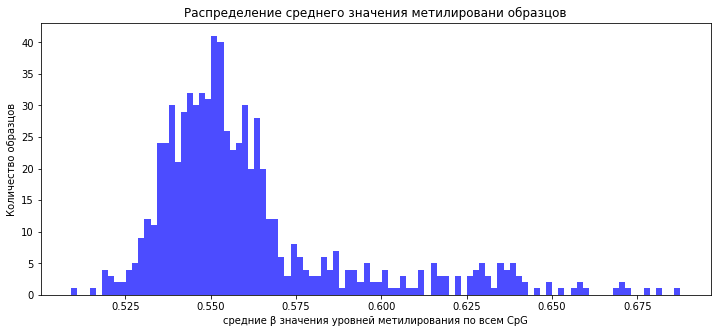

In [ ]:
fig, axes = plt.subplots(1,1, figsize = (12,5))
axes.hist(data_joined.loc[nan_thresh_sites, :].mean(axis=0),
          bins = 100,
          color = 'b',
          alpha = 0.7
         )
plt.title('Распределение среднего значения метилировани образцов')
axes.set_ylabel('Количество образцов')
axes.set_xlabel('средние β значения уровней метилирования по всем CpG')
plt.show()

## Загрузка описаний образцов

In [ ]:
samples_descriptions = pd.read_csv(path_main_dir + "/preprocessed/descriptions_samples.csv",
                          index_col=0)

In [ ]:
samples_descriptions

,Sample_geo_accession,sex,age,group
X1,GSM2333901,Male,72,70_74
X2,GSM2333902,Male,55,55_59
X3,GSM2333903,Male,23,20_24
X4,GSM2333904,Male,86,85_89
X5,GSM2333905,Male,74,70_74
...,...,...,...,...
X728,GSM2334631,Male,72,70_74
X729,GSM2334632,Male,54,50_54
X730,GSM2334633,Female,52,50_54
X731,GSM2334634,Female,45,45_49


## Загрузка дополнительных признаков образцов

In [ ]:
additional_desсriptions = pd.read_csv(
    path_main_dir+"/preprocessed/desсriptions_samples_additional.csv",
    index_col = 0
    )

In [ ]:
additional_desсriptions

,Unnamed: 1,year_of_collection,smoke,X9:136141870:C:T,exm792804,Adrenomedullin,CCL24,CCL19,CD30:L,CXCL10,...,Sample_Group,CD8T,CD4T,NK,Bcell,Mono,Gran,KA,Slide,chip:ass
index,,,,,,,,,,,,,,,,,,,,,
X1,GSM2333901,2006,0.0,1.0,1.0,-1.375617,0.187847,-0.442783,1.426913,-0.388297,...,2013,0.000000,0.100050,0.103269,0.015374,0.051578,0.728901,KA06,9370847096,7.0
X2,GSM2333902,2006,0.0,0.0,2.0,0.477876,-0.039464,0.787021,NaN,0.110696,...,2013,0.007585,0.219594,0.097459,0.036715,0.094437,0.553426,KA06,9376538120,7.0
X3,GSM2333903,2006,0.0,0.0,1.0,1.211762,0.641018,1.606884,NaN,-1.509525,...,2012,0.000000,0.018278,0.005066,0.035204,0.092227,0.827294,KA06,7766148053,7.0
X4,GSM2333904,2006,0.0,0.0,1.0,0.360086,-0.631357,0.565287,NaN,0.214688,...,2012,0.024722,0.179235,0.152868,0.020081,0.113306,0.496979,KA06,7766148077,7.0
X5,GSM2333905,2006,0.0,0.0,1.0,0.126589,0.301735,-0.360086,-0.790104,0.931642,...,2013,0.012076,0.208174,0.068129,0.047263,0.087617,0.581739,KA06,9370847096,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X728,GSM2334631,2009,0.0,1.0,0.0,-1.342502,-1.280357,-2.192664,1.571841,-1.118441,...,2012,0.112239,0.238704,0.086998,0.087370,0.072453,0.430909,KA09,7766148080,3.0
X729,GSM2334632,2009,0.0,0.0,1.0,-0.765689,0.094831,-0.150490,-0.950826,0.115991,...,2012,0.130784,0.234445,0.091153,0.076919,0.067728,0.426284,KA09,7766148080,3.0
X730,GSM2334633,2009,2.0,1.0,0.0,2.088796,2.680773,0.039464,NaN,-0.360086,...,2012,0.122360,0.154988,0.032996,0.065739,0.101473,0.547858,KA09,7766148084,4.0


In [ ]:
additional_desсriptions.columns

Index(['Unnamed: 1', ' year_of_collection', ' smoke', ' X9:136141870:C:T',
       ' exm792804', ' Adrenomedullin', ' CCL24', ' CCL19', ' CD30:L',
       ' CXCL10', ' CXCL11', ' CXCL13', ' CXCL5', ' Cystatin_B', ' E:selectin',
       ' Ep:CAM', ' Flt3L', ' Follistatin', ' GDF:15', ' Galectin:3',
       ' HB:EGF', ' WFDC2', ' IL:12', ' IL17RB', ' IL2RA', ' IL6RA',
       ' Kallikrein:11', ' MCP:1', ' MIA', ' MIC:A', ' MPO', ' Midkine',
       ' PECAM:1', ' PlGF', ' Stem_cell_factor', ' TIE2', ' TNF:RI',
       ' TNFRSF4', ' VEGF:A', ' VEGFR:2', ' SRC', ' TRAIL', ' IL27:A',
       ' CXCL1', ' FGF:23', ' IL:18', ' HSP_27', ' MMP:1', ' RETN', ' CHI3L1',
       ' ST2', ' TIM', ' mAmP', ' TM', ' MMP:10', ' CCL4', ' RAGE', ' MMP:7',
       ' CXCL6', ' Dkk:1', ' GAL', ' AGRP', ' CD40', ' t:PA', ' ESM:1',
       ' MMP:12', ' CX3CL1', ' NEMO', ' ECP', ' Sample_Group', ' CD8T',
       ' CD4T', ' NK', ' Bcell', ' Mono', ' Gran', ' KA', ' Slide',
       ' chip:ass'],
      dtype='object')

## Загрузка описаний сайтов метилирования

In [ ]:
sites_descriptions = pd.read_csv(path_main_dir+"/preprocessed/descriptions_sites.csv",
                                index_col = 0)

C:\Users\IvanovNikita\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (15,36) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [ ]:
sites_descriptions

,Name,AddressA_ID,AlleleA_ProbeSeq,AddressB_ID,AlleleB_ProbeSeq,Infinium_Design_Type,Next_Base,Color_Channel,Forward_Sequence,Genome_Build,...,Enhancer,HMM_Island,Regulatory_Feature_Name,Regulatory_Feature_Group,DHS,RANGE_START,RANGE_END,RANGE_GB,SPOT_ID,Most_Common_Gene
ID,,,,,,,,,,,,,,,,,,,,,
cg00000029,cg00000029,14782418,AACTATACTAACRAAAAAATATCCAAAAAACACTAACRTATAAAAA...,NaN,NaN,II,NaN,NaN,TTTTTTAGATAAGGATATCCAGGCGATGAGGAAGTTTTACTTCTGG...,37.0,...,NaN,NaN,16:53467838-53469685,Promoter_Associated,True,53468112.0,53468235.0,NC_000016.9,NaN,RBL2
cg00000108,cg00000108,12709357,ATACAATAAAACAAACCTAAAATAATCCTAACTCCRCTATCATCCT...,NaN,NaN,II,NaN,NaN,TCCATTTTGAAGGAAAAAAATGAAGGCTCTGAAAGTGTAAATCGCT...,37.0,...,NaN,NaN,NaN,NaN,NaN,37459206.0,37459329.0,NC_000003.11,NaN,C3orf35
cg00000109,cg00000109,59755374,CAATACTAACAAACACATATACCCCCCCACAAATCTTAACTTCTAA...,NaN,NaN,II,NaN,NaN,GCCTTAGTCCTGAATGAGCCATTTCTCTAAGAAGTCCTGGCTTCTT...,37.0,...,NaN,NaN,NaN,NaN,NaN,171916037.0,171916160.0,NC_000003.11,NaN,FNDC3B
cg00000165,cg00000165,12637463,CAAAATCTATTAATACAATAACTTTTAATAAAACAACTAAAACACA...,NaN,NaN,II,NaN,NaN,CTAAGTGCAGTCAGGATCTGTTAGTACAGTGGCTTTTGATGGAACA...,37.0,...,True,1:90967262-90967361,NaN,NaN,NaN,91194674.0,91194797.0,NC_000001.10,NaN,NaN
cg00000236,cg00000236,12649348,TATAACRTCATATTAAAAAAAACRATCTAACCCACCAATTTATACA...,NaN,NaN,II,NaN,NaN,CTCAGCGACAGTGTAGCGTCATGTTAGAGGAGACGATCTGACCCAC...,37.0,...,NaN,NaN,NaN,NaN,NaN,42263294.0,42263417.0,NC_000008.10,NaN,VDAC3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rs9363764,rs9363764,36689314,TAACTCCCTACCACCTAAAACAAAACAATAATACACTAACTAATTT...,NaN,NaN,II,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs9363764,NaN
rs939290,rs939290,70759471,ATTTTATTTTCACTTTCCACAACCATAAACCCTTCCACCCAACATA...,NaN,NaN,II,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs939290,NaN
rs951295,rs951295,11711409,AACAAACAAAAATACTACTCACAACTCTACTCATTAAAAAAACTCC...,39778441.0,AACAAACAAAAATACTACTCACAACTCTACTCATTAAAAAAACTCC...,I,C,Grn,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs951295,NaN


In [ ]:
sites_descriptions.columns

Index(['Name', 'AddressA_ID', 'AlleleA_ProbeSeq', 'AddressB_ID',
       'AlleleB_ProbeSeq', 'Infinium_Design_Type', 'Next_Base',
       'Color_Channel', 'Forward_Sequence', 'Genome_Build', 'CHR', 'MAPINFO',
       'SourceSeq', 'Chromosome_36', 'Coordinate_36', 'Strand', 'Probe_SNPs',
       'Probe_SNPs_10', 'Random_Loci', 'Methyl27_Loci', 'UCSC_RefGene_Name',
       'UCSC_RefGene_Accession', 'UCSC_RefGene_Group', 'UCSC_CpG_Islands_Name',
       'Relation_to_UCSC_CpG_Island', 'Phantom', 'DMR', 'Enhancer',
       'HMM_Island', 'Regulatory_Feature_Name', 'Regulatory_Feature_Group',
       'DHS', 'RANGE_START', 'RANGE_END', 'RANGE_GB', 'SPOT_ID',
       'Most_Common_Gene'],
      dtype='object')

## Фильтрация данных

В таблице с данными метилирования оставим только сайты у которых есть привязка к гену, не более 1% пропусков, и p-value меньше 0.01 для 99% образцов, а также отфильтруем образцы оставив только те, у которых заполнены поля возраста и пола в таблице описания образцов.

In [ ]:
# Сайты у которых нет привязки к гену
sites_genesless = sites_descriptions.index[sites_descriptions['Most_Common_Gene'].isna()] 
sites_genesless

Index(['cg00000165', 'cg00000363', 'cg00000948', 'cg00001249', 'cg00001261',
       'cg00001269', 'cg00001593', 'cg00001747', 'cg00001809', 'cg00001930',
       ...
       'rs7746156', 'rs798149', 'rs845016', 'rs877309', 'rs9292570',
       'rs9363764', 'rs939290', 'rs951295', 'rs966367', 'rs9839873'],
      dtype='object', name='ID', length=119977)

In [ ]:
# Сайты метелирования c пропусками
nan_thresh_sites = data_joined.index[data_joined.isna().any(axis = 1)]
nan_thresh_sites

Index(['cg00050873', 'cg00212031', 'cg00213748', 'cg00214611', 'cg00455876',
       'cg02004872', 'cg02011394', 'cg02050847', 'cg02233190', 'cg02839557',
       ...
       'cg27662284', 'ch.22.138449R', 'ch.22.147839R', 'ch.22.149158R',
       'ch.22.243204R', 'ch.22.363412F', 'ch.22.436090R', 'ch.22.528917R',
       'ch.22.772318F', 'ch.22.44116734F'],
      dtype='object', name='ID_REF', length=35309)

In [ ]:
# Cайты метилирования, для которых 
# p-value меньше 0.01 для не менее чем 99% образцов
p_value_thresh_sites = p_value_detection.index\
    [((p_value_detection >= 0.01).sum(axis = 1)\
      / p_value_detection.shape[1]) >= 0.01]

p_value_thresh_sites

Index(['cg00050873', 'cg00212031', 'cg00213748', 'cg00214611', 'cg00455876',
       'cg02011394', 'cg02050847', 'cg02233190', 'cg02839557', 'cg02842889',
       ...
       'cg12478092', 'cg13116946', 'cg14042597', 'cg15044932', 'cg16997375',
       'cg17387122', 'cg21442271', 'cg22666875', 'ch.22.363412F',
       'ch.22.436090R'],
      dtype='object', name='ID_REF', length=2634)

In [ ]:
sites_to_drop = sites_genesless\
                .union(nan_thresh_sites)\
                .union(p_value_thresh_sites)

sites_to_drop

Index(['cg00000165', 'cg00000363', 'cg00000948', 'cg00001249', 'cg00001261',
       'cg00001269', 'cg00001593', 'cg00001747', 'cg00001793', 'cg00001809',
       ...
       'rs7746156', 'rs798149', 'rs845016', 'rs877309', 'rs9292570',
       'rs9363764', 'rs939290', 'rs951295', 'rs966367', 'rs9839873'],
      dtype='object', length=145212)

In [ ]:
samples_descriptions[(samples_descriptions[['sex','age']].isna().all(axis = 1)== False)]

,Sample_geo_accession,sex,age,group
X1,GSM2333901,Male,72,70_74
X2,GSM2333902,Male,55,55_59
X3,GSM2333903,Male,23,20_24
X4,GSM2333904,Male,86,85_89
X5,GSM2333905,Male,74,70_74
...,...,...,...,...
X728,GSM2334631,Male,72,70_74
X729,GSM2334632,Male,54,50_54
X730,GSM2334633,Female,52,50_54
X731,GSM2334634,Female,45,45_49


In [ ]:
data_methylation = data_joined.query('index not in @sites_to_drop'
                                    ).loc[:, samples_descriptions.index]
display(data_methylation.shape)
display(data_methylation.head())
display(data_methylation.tail())

(340365, 729)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X723,X724,X725,X726,X727,X728,X729,X730,X731,X732
ID_REF,,,,,,,,,,,,,,,,,,,,,
cg01707559,0.091756,0.057094,0.070700,0.122446,0.086404,0.226748,0.075118,0.049789,0.279977,0.362271,...,0.050549,0.075837,0.248150,0.078525,0.134440,0.085143,0.081432,0.228677,0.222310,0.122803
cg02494853,0.032790,0.029831,0.024936,0.046584,0.020204,0.097938,0.031592,0.041213,0.052293,0.049333,...,0.013448,0.037088,0.037324,0.026454,0.084670,0.022366,0.024528,0.037231,0.045762,0.191773
cg03706273,0.041566,0.062096,0.025517,0.061010,0.030409,0.255483,0.029638,0.076723,0.089194,0.065940,...,0.009035,0.037083,0.111043,0.021373,0.062509,0.042210,0.064298,0.096641,0.047448,0.073706
cg15295597,0.053220,0.029649,0.025265,0.040190,0.034945,0.139337,0.024848,0.033814,0.069463,0.029122,...,0.011668,0.060157,0.035454,0.016260,0.092267,0.035460,0.046284,0.049554,0.052715,0.167146
cg27539833,0.906486,0.923817,0.900892,0.922680,0.905139,0.900159,0.910428,0.895712,0.915642,0.918314,...,0.967174,0.926606,0.862893,0.925957,0.937382,0.934757,0.924624,0.892350,0.918526,0.904782


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X723,X724,X725,X726,X727,X728,X729,X730,X731,X732
ID_REF,,,,,,,,,,,,,,,,,,,,,
ch.22.728807R,0.106295,0.073127,0.115979,0.092891,0.150775,0.062394,0.120724,0.119934,0.160917,0.138326,...,0.053606,0.098119,0.156609,0.082644,0.127034,0.081969,0.123049,0.147310,0.077081,0.100998
ch.22.734399R,0.087009,0.194002,0.130208,0.120509,0.136613,0.113992,0.145297,0.184315,0.187541,0.151660,...,0.061082,0.195230,0.092118,0.134737,0.147923,0.146447,0.134767,0.123749,0.205997,0.126280
ch.22.740407F,0.021154,0.027324,0.023570,0.025149,0.027056,0.013594,0.012174,0.024958,0.029098,0.039945,...,0.020774,0.027415,0.013585,0.025202,0.023264,0.027409,0.026960,0.031105,0.012739,0.021916
ch.22.757911F,0.039410,0.046239,0.020225,0.019679,0.029783,0.050819,0.034501,0.059055,0.066130,0.052018,...,0.026359,0.031102,0.035200,0.022480,0.049777,0.048689,0.038484,0.021322,0.056414,0.022184
ch.22.909671F,0.057891,0.031434,0.048693,0.033916,0.103210,0.144609,0.087954,0.106434,0.148038,0.221108,...,0.158166,0.064856,0.141411,0.102136,0.091702,0.174574,0.122583,0.083451,0.116304,0.057085


In [ ]:
# Сохраним отфильтрованные данные
data_methylation.to_csv(path_main_dir+'/preprocessed/data_methylation_clear.csv')

In [ ]:
data_methylation = pd.read_csv(
                        path_main_dir+'/preprocessed/data_methylation_clear.csv',
                        index_col = 0
                        )

In [ ]:
display(data_methylation.shape)
display(data_methylation.head())
display(data_methylation.tail())

(340365, 729)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X723,X724,X725,X726,X727,X728,X729,X730,X731,X732
ID_REF,,,,,,,,,,,,,,,,,,,,,
cg01707559,0.091756,0.057094,0.070700,0.122446,0.086404,0.226748,0.075118,0.049789,0.279977,0.362271,...,0.050549,0.075837,0.248150,0.078525,0.134440,0.085143,0.081432,0.228677,0.222310,0.122803
cg02494853,0.032790,0.029831,0.024936,0.046584,0.020204,0.097938,0.031592,0.041213,0.052293,0.049333,...,0.013448,0.037088,0.037324,0.026454,0.084670,0.022366,0.024528,0.037231,0.045762,0.191773
cg03706273,0.041566,0.062096,0.025517,0.061010,0.030409,0.255483,0.029638,0.076723,0.089194,0.065940,...,0.009035,0.037083,0.111043,0.021373,0.062509,0.042210,0.064298,0.096641,0.047448,0.073706
cg15295597,0.053220,0.029649,0.025265,0.040190,0.034945,0.139337,0.024848,0.033814,0.069463,0.029122,...,0.011668,0.060157,0.035454,0.016260,0.092267,0.035460,0.046284,0.049554,0.052715,0.167146
cg27539833,0.906486,0.923817,0.900892,0.922680,0.905139,0.900159,0.910428,0.895712,0.915642,0.918314,...,0.967174,0.926606,0.862893,0.925957,0.937382,0.934757,0.924624,0.892350,0.918526,0.904782


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X723,X724,X725,X726,X727,X728,X729,X730,X731,X732
ID_REF,,,,,,,,,,,,,,,,,,,,,
ch.22.728807R,0.106295,0.073127,0.115979,0.092891,0.150775,0.062394,0.120724,0.119934,0.160917,0.138326,...,0.053606,0.098119,0.156609,0.082644,0.127034,0.081969,0.123049,0.147310,0.077081,0.100998
ch.22.734399R,0.087009,0.194002,0.130208,0.120509,0.136613,0.113992,0.145297,0.184315,0.187541,0.151660,...,0.061082,0.195230,0.092118,0.134737,0.147923,0.146447,0.134767,0.123749,0.205997,0.126280
ch.22.740407F,0.021154,0.027324,0.023570,0.025149,0.027056,0.013594,0.012174,0.024958,0.029098,0.039945,...,0.020774,0.027415,0.013585,0.025202,0.023264,0.027409,0.026960,0.031105,0.012739,0.021916
ch.22.757911F,0.039410,0.046239,0.020225,0.019679,0.029783,0.050819,0.034501,0.059055,0.066130,0.052018,...,0.026359,0.031102,0.035200,0.022480,0.049777,0.048689,0.038484,0.021322,0.056414,0.022184
ch.22.909671F,0.057891,0.031434,0.048693,0.033916,0.103210,0.144609,0.087954,0.106434,0.148038,0.221108,...,0.158166,0.064856,0.141411,0.102136,0.091702,0.174574,0.122583,0.083451,0.116304,0.057085


## Подготовка данных для моделирования

In [ ]:
male_columns = samples_descriptions.query('sex == "Male"').index
female_columns = samples_descriptions.query('sex == "Female"').index

In [ ]:
data_methylation_for_ml_male = data_methylation[male_columns]
data_methylation_for_ml_female = data_methylation[female_columns]
print(data_methylation_for_ml_male.shape)
print(data_methylation_for_ml_female.shape)

(340365, 341)
(340365, 388)


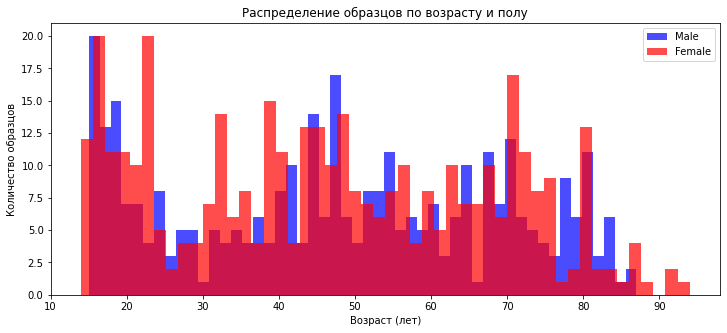

In [ ]:
fig, axes = plt.subplots(1,1, figsize = (12,5))

axes.hist(samples_descriptions[samples_descriptions['sex'] == 'Male']['age'].sort_values(),
         bins = 50,
         alpha=0.7,
         label = 'Male',
          color = 'b',
        )
axes.hist(samples_descriptions[samples_descriptions['sex'] == 'Female']['age'].sort_values(),
         bins = 50,
         alpha=0.7,
         label = 'Female',
          color = 'r',
        )
plt.title('Распределение образцов по возрасту и полу')
axes.set_ylabel('Количество образцов')
axes.set_xlabel('Возраст (лет)')
plt.legend()
plt.show()

## Загрузка разбивки сайтов по группам

In [ ]:
hallmarks_genes = pd.read_csv(
                            path_root_dir\
                            +r'/hallmarks_genes'/
                            +r'/hallmark_genes.csv',
                            index_col = 0
                             )

In [ ]:
hallmarks_genes

,group,genes
2,TNFA_SIGNALING_VIA_NFKB,JUNB
3,TNFA_SIGNALING_VIA_NFKB,CXCL2
4,TNFA_SIGNALING_VIA_NFKB,ATF3
5,TNFA_SIGNALING_VIA_NFKB,NFKBIA
6,TNFA_SIGNALING_VIA_NFKB,TNFAIP3
...,...,...
37,PANCREAS_BETA_CELLS,PAK3
38,PANCREAS_BETA_CELLS,G6PC2
39,PANCREAS_BETA_CELLS,PKLR
40,PANCREAS_BETA_CELLS,LMO2


## Предсказание возраста по профилю метилирования

### Построение моделей на данных всех сайтов

Проведем отбор сайтов с помощью регуляризации линейных моделей ElasticNet -- объединяющей два подхода добавления к функции потерь модуля вектора весов (l1 регуляризация) и квадрата нормы(l2 регуляризация) в пропорциях заданных коэффициентом l1_ratio

In [ ]:
# Напишем функцию подсчета абсолютной средней ошибки
def mae(true: np.array, predict: np.array) -> float:
    result = sum(np.abs(true - predict)) / true.shape[0]
    return result

In [ ]:
samples_descriptions

,Sample_geo_accession,sex,age,group
X1,GSM2333901,Male,72,70_74
X2,GSM2333902,Male,55,55_59
X3,GSM2333903,Male,23,20_24
X4,GSM2333904,Male,86,85_89
X5,GSM2333905,Male,74,70_74
...,...,...,...,...
X728,GSM2334631,Male,72,70_74
X729,GSM2334632,Male,54,50_54
X730,GSM2334633,Female,52,50_54
X731,GSM2334634,Female,45,45_49


In [ ]:
samples_train = samples_descriptions.sample(frac = 0.8, random_state = 12345)[['sex','age']]
samples_test = samples_descriptions.query('index not in @samples_train.index')[['sex','age']]

In [ ]:
samples_train.age.hist(bins = 20,density = True, alpha = 0.7, color = 'r', label = 'Train')
samples_test.age.hist(bins = 20,density = True, alpha = 0.7, color = 'b', label = 'Test')   
plt.legend()
plt.show()

In [ ]:
male_samples_train = samples_train.query('sex == "Male"')
female_samples_train = samples_train.query('sex == "Female"')

In [ ]:
male_samples_test = samples_test.query('sex == "Male"')
female_samples_test = samples_test.query('sex == "Female"')

In [ ]:
# Множества сайтов метилирования для тестовых и тренировочных образцов
male_train_x = data_methylation[male_samples_train.index].T
male_test_x = data_methylation[male_samples_test.index].T

female_train_x = data_methylation[female_samples_train.index].T
female_test_x = data_methylation[female_samples_test.index].T

male_train_y = male_samples_train['age'].values
female_train_y = female_samples_train['age'].values

male_test_y = male_samples_test['age'].values
female_test_y = female_samples_test['age'].values

In [ ]:
train_test_data = {'male_train_x' : male_train_x,
                   'male_test_x' : male_test_x,
                   'female_train_x' : female_train_x,
                   'female_test_x' : female_test_x,
                   'male_train_y' : male_train_y,
                   'female_train_y' : female_train_y,
                   'male_test_y' : male_test_y,
                   'female_test_y' : female_test_y}

for x in list(train_test_data.keys()):
    print(x, train_test_data[x].shape)

male_train_x (275, 340365)
male_test_x (66, 340365)
female_train_x (308, 340365)
female_test_x (80, 340365)
male_train_y (275,)
female_train_y (308,)
male_test_y (66,)
female_test_y (80,)


In [ ]:
start = time.time()
elastic_net_male = ElasticNet(alpha = 0.05,
                              l1_ratio=0.54,
                              max_iter = 2000,
                              random_state = 12345                               
                              )


elastic_net_female = ElasticNet(alpha = 0.01,
                                l1_ratio=0.45,
                                max_iter= 3000,
                                random_state = 12345                               
                                )

elastic_net_male.fit(male_train_x, male_train_y)
print('|', end = '')

elastic_net_female.fit(female_train_x, female_train_y)
print('|')

print('Время обучения составило', str(int(time.time() - start)), 'сек')

||
Время обучения составило 240 сек


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.278e+01, tolerance: 1.288e+01


In [ ]:
mae_elastic_net_male = mae(male_test_y, elastic_net_male.predict(male_test_x))
mae_elastic_net_female = mae(female_test_y, elastic_net_female.predict(female_test_x))

print('mae_elastic_net_male', mae_elastic_net_male)
print('mae_elastic_net_female', mae_elastic_net_female)

mae_elastic_net_male 3.6363149455499495
mae_elastic_net_female 4.133725928203097


In [ ]:
# сохраним веса моделей в таблицу
elastic_net_weights = pd.DataFrame(elastic_net_male.coef_[elastic_net_male.coef_ != 0],
    index = male_train_x.columns[elastic_net_male.coef_ != 0],
            columns = ['weight_male'])\
.join(pd.DataFrame(elastic_net_female.coef_[elastic_net_female.coef_ != 0],
    index = female_train_x.columns[elastic_net_female.coef_ != 0],
            columns = ['weight_female']), how = 'outer')

elastic_net_weights = elastic_net_weights.dropna()

elastic_net_weights

,weight_male,weight_female
ID_REF,,
cg00029246,-0.350723,-0.212600
cg00059225,0.008058,0.403582
cg00094518,0.465700,0.425407
cg00144180,0.549912,0.703477
cg00176863,0.274506,0.456309
...,...,...
cg27367526,-0.344875,-0.383290
cg27436995,2.156537,1.853273
cg27549720,0.188694,0.234936


In [ ]:
# Объединим полученную таблицу с описаниями сайтов
elastic_net_sites = elastic_net_weights[['weight_male', 'weight_female']].join(sites_descriptions, how = 'left')

In [ ]:
elastic_net_sites.to_csv(path_main_dir+'/models/elastic_net_sites_cuted.csv')

In [ ]:
elastic_net_weights.to_csv(path_main_dir+'/models/elastic_net_weights_cuted.csv')

## Визуализация весов модели

In [ ]:
elastic_net_weights = pd.read_csv(path_main_dir+'/models/elastic_net_weights_cuted.csv',
                                  index_col=0
                                 )

In [ ]:
elastic_net_sites = pd.read_csv(path_main_dir+'/models/elastic_net_sites_cuted.csv',
                                  index_col=0
                                 )

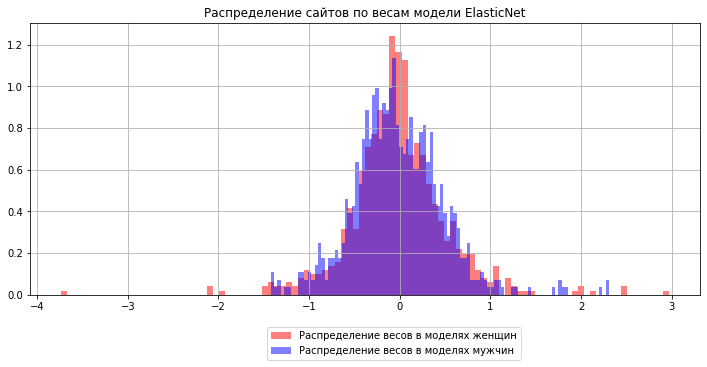

In [ ]:
# Выведем график распределения признаков по весам
plt.figure(figsize = (12,5))

elastic_net_weights[
    'weight_male']\
            .hist(bins=100,
                  density = True,
                  color = 'r',
                  alpha = 0.5,
                  label = 'Распределение весов в моделях женщин'
                 )

elastic_net_weights[
    'weight_female']\
            .hist(bins=100,
                  density = True,
                  color = 'b',
                  alpha = 0.5,
                  label = 'Распределение весов в моделях мужчин'
                 )

plt.legend(
#   loc='lower left',
    bbox_to_anchor=(0.74, -0.1)
)
plt.title('Распределение сайтов по весам модели ElasticNet')
plt.show()

In [ ]:
# Создадим таблицу с группировкой сайтов по группам
elastic_net_hallmarks = elastic_net_sites[['weight_male','weight_female','Name', 'Most_Common_Gene']]

In [ ]:
elastic_net_hallmarks = elastic_net_hallmarks\
                    .set_index('Most_Common_Gene', drop = True)\
                    .join(hallmarks_genes.set_index('genes', drop = True)\
                    , how = 'left')

In [ ]:
elastic_net_hallmarks = elastic_net_hallmarks.reset_index()
elastic_net_hallmarks.columns = ['gene','weight_male','weight_female','cpg_name','group']
elastic_net_hallmarks

,gene,weight_male,weight_female,cpg_name,group
0,A2BP1,-0.141245,-0.203486,cg03623568,NaN
1,AAK1,0.370512,-0.168234,cg17149911,NaN
2,ABCC4,-0.354410,-0.254976,cg05412028,ANDROGEN_RESPONSE
3,ABCC4,-0.571178,-0.524258,cg26685941,ANDROGEN_RESPONSE
4,ABCC5,-0.052006,-0.622407,cg01324343,P53_PATHWAY
...,...,...,...,...,...
859,ZP2,-0.439447,-0.057365,cg06819923,NaN
860,ZYG11A,0.347869,0.528300,cg06335143,NaN
861,ZYG11A,0.342286,0.268851,cg06784991,NaN
862,ZYG11A,0.463173,0.653177,cg24466241,NaN


In [ ]:
# Для удобства сравнения разобъем все сайты по вкладу 
# в формулу возраста на негативные и позитивные
positive_male = elastic_net_hallmarks[elastic_net_hallmarks['weight_male'] > 0].drop('weight_female', axis = 1)
negative_male = elastic_net_hallmarks[elastic_net_hallmarks['weight_male'] < 0].drop('weight_female', axis = 1)

positive_female = elastic_net_hallmarks[elastic_net_hallmarks['weight_female'] > 0].drop('weight_male', axis = 1)
negative_female = elastic_net_hallmarks[elastic_net_hallmarks['weight_female'] < 0].drop('weight_male', axis = 1)

In [ ]:
# Соберем данные в словарь
hallmarks_elastic_net = {
    'positive_male':positive_male,
    'negative_male':negative_male,
    'positive_female':positive_female,
    'negative_female':negative_female
}

In [ ]:
for key, data in hallmarks_elastic_net.items():
    hallmarks_elastic_net[key] = data.join(data.groupby(by='group').sum(),
                     rsuffix='_group',
                     on = 'group',
                     how = 'outer')

In [ ]:
hallmarks_elastic_net['positive_male']

,gene,weight_male,cpg_name,group,weight_male_group
1,AAK1,0.370512,cg17149911,NaN,NaN
21,ACSF3,0.602336,cg03172657,NaN,NaN
26,ACTL6B,0.098378,cg24471254,NaN,NaN
28,ADAMTSL5,0.152500,cg22994198,NaN,NaN
29,ADCY5,0.573249,cg04908625,NaN,NaN
...,...,...,...,...,...
701,SCG3,0.203600,cg01908954,SPERMATOGENESIS,0.203600
750,SST,0.489826,cg00481951,PANCREAS_BETA_CELLS,1.099156
751,SST,0.609330,cg25478614,PANCREAS_BETA_CELLS,1.099156
755,STK25,0.499487,cg09289202,REACTIVE_OXYGEN_SPECIES_PATHWAY,0.499487


In [ ]:
for key, data in hallmarks_elastic_net.items():
    print(key, data.shape, sum(abs(data.iloc[:, 1])))

positive_male (379, 5) 157.73781078312314
negative_male (485, 5) 176.42064291737287
positive_female (381, 5) 154.31943303990627
negative_female (483, 5) 180.18448167783959


In [ ]:
fig = make_subplots(1,1)

for group, data in hallmarks_elastic_net.items():
    
    data = data.dropna()

    fig.add_trace(go.Scatter(
        x = data.iloc[:, 1],
        y = data['group'].str.lower(),
        text = data['gene'],
        mode = 'markers',
        marker = dict(
            size = abs(data.iloc[:, 1])*30
        ),
        name = group
        ))
    
fig.update_layout(
    
    height = 1000,
    width = 1500,
    legend = dict(itemsizing = 'constant'),
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    xaxis = dict(),
    title = dict( 
        text = 'Распределение коэффициентов '/
                +'CpG сайтов (n = 150) в модели '/
                +'часов метилирования ElasticNet'/
                ' в разрезе групп генов',
        xanchor = 'center',
        yanchor = 'top',
        x = 0.5,
        y = 0.97
    ))

fig.update_xaxes(
        side = 'top',
        title_text = "Коэффициент веса в модели",
        title_standoff = 5)

fig.update_yaxes(
        title_text = "Функциональная группа сайтов",
        title_standoff = 25)

fig.write_html(path_main_dir+'/visualizations/elastic_net_weights_by_groups.html')

## Повторное обучение моделей на отобранных сайтах

In [ ]:
#Оставим сайты имеющие наибольший модуль веса в подгруппах у мужчин и женщин
elastic_net_hallamrks_sites = elastic_net_hallmarks.copy()

elastic_net_hallamrks_sites['weight_male_abs'] = abs(elastic_net_hallmarks['weight_male'])
elastic_net_hallamrks_sites['weight_female_abs'] = abs(elastic_net_hallmarks['weight_female'])

top_male = elastic_net_hallamrks_sites.sort_values(by = 'weight_male_abs', ascending = False)['cpg_name'].values[:95]
top_female = elastic_net_hallamrks_sites.sort_values(by = 'weight_female_abs', ascending = False)['cpg_name'].values[:90]

top_weighted_male = set(top_male).union(top_female)

top_male = elastic_net_hallamrks_sites.sort_values(by = 'weight_male_abs', ascending = False)['cpg_name'].values[:20]
top_female = elastic_net_hallamrks_sites.sort_values(by = 'weight_female_abs', ascending = False)['cpg_name'].values[:90]

top_weighted_female = set(top_male).union(top_female)

# Выведем количество оставшихся сайтов
display(len(top_weighted_male))
display(len(top_weighted_female))

106

72

In [ ]:
male_scaler = StandardScaler()
female_scaler = StandardScaler()

In [ ]:
male_train_x_scaled = pd.DataFrame(male_scaler.fit_transform(male_train_x),
                      index = male_train_x.index,
                      columns = male_train_x.columns)
male_test_x_scaled = pd.DataFrame(male_scaler.transform(male_test_x),
                     index = male_test_x.index,
                     columns = male_test_x.columns)

female_train_x_scaled = pd.DataFrame(female_scaler.fit_transform(female_train_x),
                        index = female_train_x.index,
                        columns = female_train_x.columns)
female_test_x_scaled = pd.DataFrame(female_scaler.transform(female_test_x),
                       index = female_test_x.index,
                       columns = female_test_x.columns)

display(male_train_x_scaled.mean(axis = 1).mean())
display(male_test_x_scaled.mean(axis = 1).mean())

display(female_train_x_scaled.mean(axis = 1).mean())
display(female_test_x_scaled.mean(axis = 1).mean())

-1.1505947709751622e-17

-0.026009978714196677

5.479022718929344e-17

-0.00043182696641060335

In [ ]:
elastic_net_male = ElasticNet(alpha = 0.003,
                           l1_ratio=0.54,
                               max_iter = 3000,
                            
                               random_state = 12345                               
                              )

elastic_net_female = ElasticNet(alpha = 0.003,
                             l1_ratio=0.45,
                                max_iter= 3000,
                            
                               random_state = 12345                               
                              )

elastic_net_male.fit(male_train_x[list(top_weighted_male)], male_train_y)
elastic_net_female.fit(female_train_x[list(top_weighted_female)], female_train_y)

mae_elastic_net_male = mae(male_test_y, elastic_net_male.predict(male_test_x[list(top_weighted_male)]))
mae_elastic_net_female = mae(female_test_y, elastic_net_female.predict(female_test_x[list(top_weighted_female)]))

print('mae_elastic_net_male', mae_elastic_net_male)
print('mae_elastic_net_female', mae_elastic_net_female)
print('Total Mean', np.mean([mae_elastic_net_male, mae_elastic_net_female]))

mae_elastic_net_male 2.9271625745155707
mae_elastic_net_female 2.9663368681855413
Total Mean 2.946749721350556


In [ ]:
elastic_net_male_scaled = ElasticNet(alpha = 0.003,
                           l1_ratio=0.54,
                               max_iter = 5000,
                              fit_intercept = False,
                               random_state = 12345                               
                              )

elastic_net_female_scaled = ElasticNet(alpha = 0.003,
                             l1_ratio=0.45,
                                max_iter= 5000,
                                fit_intercept = False,
                               random_state = 12345                               
                              )

elastic_net_male_scaled.fit(male_train_x[list(top_weighted_male)], male_train_y)
elastic_net_female_scaled.fit(female_train_x[list(top_weighted_female)], female_train_y)

mae_elastic_net_male = mae(male_test_y, elastic_net_male_scaled.predict(male_test_x[list(top_weighted_male)]))
mae_elastic_net_female = mae(female_test_y, elastic_net_female_scaled.predict(female_test_x[list(top_weighted_female)]))

print('mae_elastic_net_male_scaled', mae_elastic_net_male)
print('mae_elastic_net_female_scaled', mae_elastic_net_female)
print('Total Mean', np.mean([mae_elastic_net_male, mae_elastic_net_female]))

mae_elastic_net_male_scaled 3.085879439732361
mae_elastic_net_female_scaled 3.3502476975295457
Total Mean 3.2180635686309533


C:\Users\IvanovNikita\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.744e+03, tolerance: 7.523e+01

C:\Users\IvanovNikita\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.354e+03, tolerance: 8.052e+01



In [ ]:
# Сохраним полученные модели

final_elastic_net_params = pd.DataFrame(data = elastic_net_male_scaled.get_params().values(),
             index = elastic_net_male_scaled.get_params().keys(),
             columns = ['final_elastic_net_male']
            )\
    .join(
    pd.DataFrame(data = elastic_net_female_scaled.get_params().values(),
             index = elastic_net_female_scaled.get_params().keys(),
             columns = ['final_elastic_net_female']
            )
    )

## Сохранение полученных моделей

In [ ]:
joblib.dump(elastic_net_male, path_main_dir + '/models/final_elastic_net_male.sav')
joblib.dump(elastic_net_female, path_main_dir + '/models/final_elastic_net_female.sav')

['C:\\Users\\IvanovNikita\\OneDrive - ООО «АЛЬМА Сервисез Компани»\\Рабочий стол\\bioinformatics\\geo_methylation_datasets\\GSE87571\\models\\final_elastic_net_female.sav']

In [ ]:
joblib.dump(elastic_net_male_scaled, path_main_dir + '/models/final_elastic_net_male_scaled.sav')
joblib.dump(elastic_net_female_scaled, path_main_dir + '/models/final_elastic_net_female_scaled.sav')

['C:\\Users\\IvanovNikita\\OneDrive - ООО «АЛЬМА Сервисез Компани»\\Рабочий стол\\bioinformatics\\geo_methylation_datasets\\GSE87571\\models\\final_elastic_net_female_scaled.sav']

In [ ]:
elastic_net_male = joblib.load(path_main_dir + '/models/final_elastic_net_male.sav')
elastic_net_female = joblib.load(path_main_dir + '/models/final_elastic_net_female.sav')

In [ ]:
elastic_net_male_scaled = joblib.load(path_main_dir + '/models/final_elastic_net_male_scaled.sav')
elastic_net_female_scaled = joblib.load(path_main_dir + '/models/final_elastic_net_female_scaled.sav')

In [ ]:
pd.DataFrame(top_weighted_male,
            columns = ['sites_male'],
            ).to_csv(path_main_dir + '/models/final_elastic_net_male_sites.csv')
pd.DataFrame(top_weighted_female,
            columns = ['sites_female'],
            ).to_csv(path_main_dir + '/models/final_elastic_net_female_sites.csv')

In [ ]:
final_elastic_net_sites = pd.DataFrame(
    index = male_train_x[list(top_weighted_male)].columns,
    data = elastic_net_male.coef_,
    columns = ['weight_male'])\
    .join(pd.DataFrame(
    index = female_train_x[list(top_weighted_female)].columns,
    data = elastic_net_female.coef_,
    columns = ['weight_female']),
    how ='outer')

In [ ]:
final_elastic_net_hallmarks = final_elastic_net_sites\
    .join(sites_descriptions[['Most_Common_Gene']], how = 'left')\
    .reset_index()\
    .set_index('Most_Common_Gene')\
    .join(hallmarks_genes.set_index('genes'), how = 'left')\
    .reset_index()

final_elastic_net_hallmarks.columns = ['gene', 'cpg_name', 'weight_male', 'weight_female', 'group']

In [ ]:
final_elastic_net_hallmarks = final_elastic_net_hallmarks.drop_duplicates(keep = 'first',
                                            subset = ['cpg_name'])

In [ ]:
final_elastic_net_hallmarks.to_csv(path_main_dir+'/models/final_hallmarks.csv')

In [ ]:
final_elastic_net_hallmarks = pd.read_csv(
                                path_main_dir+'/models/final_hallmarks.csv',
                                index_col = 0
                                           )
final_elastic_net_hallmarks

,gene,weight_male,weight_female,group
cpg_name,,,,
cg16867657,ELOVL2,10.650105,17.377274,ESTROGEN_RESPONSE_EARLY
cg07544187,CILP2,7.521758,14.473471,NaN
cg24724428,ELOVL2,7.053800,12.754742,ESTROGEN_RESPONSE_EARLY
cg14361627,KLF14,10.720293,10.849178,NaN
cg25410668,RPA2,6.987764,10.189043,DNA_REPAIR
...,...,...,...,...
cg07127410,ZNRF3,-4.799280,NaN,NaN
cg03873281,PDLIM4,-5.088620,NaN,EPITHELIAL_MESENCHYMAL_TRANSITION
cg01243823,NOD2,-6.311090,NaN,INFLAMMATORY_RESPONSE


In [ ]:
final_elastic_net_hallmarks.group.isna().sum()

82

## Сравнение финальной модели с часами метилирования by Horvath

Модель полученная первопроходцем в исследовании эпигенетических корреляций с процессами старения:
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4015143/

In [ ]:
horvath_clock_sites = pd.read_csv(
    path_root_dir+'/\geo_methylation_datasets/Нorvath_clock.csv',
    header=2,
    index_col=0
)

In [ ]:
horvath_clock_sites.loc[horvath_clock_sites.index[1:].intersection(final_elastic_net_hallmarks.index), :]

,CoefficientTraining,CoefficientTrainingShrunk,varByCpG,minByCpG,maxByCpG,medianByCpG,medianByCpGYoung,medianByCpGOld,Gene_ID,GenomeBuild,...,SourceVersion,TSS_Coordinate,Gene_Strand,Symbol,Synonym,Accession,GID,Annotation,Product,Marginal Age Relationship
cg09809672,-0.391319,-0.189295,0.042,0.0022,0.97,0.56,0.65,0.45,128178.0,36.0,...,36.1,234624303.0,+,EDARADD,NaN,NM_080738.2,GI:22325373,##############################################...,EDAR-associated death domain isoform B,negative
cg15804973,-0.108169,NaN,0.017,0.0000,0.84,0.26,0.34,0.22,4217.0,36.0,...,36.1,137155349.0,-,MAP3K5,ASK1; MEKK5; MAPKKK5;,NM_005923.3,GI:21536459,##############################################...,mitogen-activated protein kinase kinase kinase 5,negative
cg22947000,-0.385598,-0.358490,0.020,0.0000,0.89,0.25,0.32,0.21,53630.0,36.0,...,36.1,79829797.0,+,BCMO1,BCO; BCDO; BCMO; BCDO1; FLJ10730;,NM_017429.2,GI:74027269,beta-carotene 15; 15prime-dioxygenase 1; go_fu...,beta-carotene 15; 15prime-monooxygenase 1,negative


## Визуализация финальной модели

In [ ]:
# Для удобства сравнения разобъем все сайты по вкладу 
# в формулу возраста на негативные и позитивные
positive_male = final_elastic_net_hallmarks\
                [final_elastic_net_hallmarks\
                 ['weight_male'] > 0].drop('weight_female', axis = 1)
negative_male = final_elastic_net_hallmarks\
                [final_elastic_net_hallmarks\
                 ['weight_male'] < 0].drop('weight_female', axis = 1)

positive_female = final_elastic_net_hallmarks\
                [final_elastic_net_hallmarks\
                 ['weight_female'] > 0].drop('weight_male', axis = 1)
negative_female = final_elastic_net_hallmarks\
                [final_elastic_net_hallmarks\
                 ['weight_female'] < 0].drop('weight_male', axis = 1)

In [ ]:
# Соберем данные в словарь
final_hallmarks = {
    'positive_male':positive_male,
    'negative_male':negative_male,
    'positive_female':positive_female,
    'negative_female':negative_female
    }

In [ ]:
for key, data in final_hallmarks.items():
    final_hallmarks[key] = data.join(data.groupby(by='group').sum(),
                     rsuffix='_group',
                     on = 'group',
                     how = 'outer')

In [ ]:
for key, data in final_hallmarks.items():
    print(key, data.shape, sum(abs(data.iloc[:, 1])))

positive_male (38, 4) 169.524752207699
negative_male (58, 4) 161.20380443943375
positive_female (34, 4) 177.9503252977195
negative_female (36, 4) 138.293776824539


In [ ]:
fig = make_subplots(1,1)

colors = {
           'positive_male' : 'rgba(255, 8, 24, 0.5)',
           'positive_female' : 'rgba(255, 8, 226, 0.5)',
           'negative_male': 'rgba(8, 177, 255, 0.5)',
           'negative_female' : 'rgba(8, 255, 169, 0.5)'
        }
for group, data in final_hallmarks.items():
    
    data_groupped = data.dropna(subset = ['group'])
    data_not_groupped = data.loc[data['group'].isna() == True]

    fig.add_trace(go.Scatter(
        x = data_groupped.iloc[:, 1],
        y = data_groupped['group'].str.lower(),
        text = data_groupped['gene'],
        mode = 'markers',
        marker = dict(
                 size = abs(data_groupped.iloc[:, 1])*8,
                 color = colors[group]
                 ),
        name = group
        ))
    
    fig.add_trace(go.Scatter(
        x = data_not_groupped.iloc[:, 1],
        y = data_not_groupped['gene'].str.lower(),
        text = data_not_groupped['gene'],
        mode = 'markers',
        marker = dict(
                 size = abs(data_not_groupped.iloc[:, 1])*8,
                 color = colors[group]
                 ),
        name = group + ' гены без привязки к группам'
        ))
    
fig.update_layout(
    
    height = 1000,
    width = 1500,
    legend = dict(itemsizing = 'constant'),
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    xaxis = dict(),
    title = dict( 
        text = 'Распределение коэффициентов '/
                +'CpG сайтов (n = 106) в модели '/
                +'часов метилирования ElasticNet'/
                ' в разрезе групп генов',
        xanchor = 'center',
        yanchor = 'top',
        x = 0.5,
        y = 0.97
    ))

fig.update_xaxes(
        side = 'top',
        title_text = "Коэффициент веса в модели",
        title_standoff = 5)

fig.update_yaxes(
        title_text = "Функциональная группа генов/ген связаный с CpG)",
        title_standoff = 25)

fig.write_html(path_main_dir+'/visualizations/final_elastic_net_weights_by_groups.html')

## Визуализация вклада генов в возраст

In [ ]:
samples_males = samples_descriptions.index[samples_descriptions['sex'] == 'Male']
samples_females = samples_descriptions.index[samples_descriptions['sex'] == 'Female']

display(samples_males.shape)
display(samples_females.shape)

(341,)

(388,)

In [ ]:
# Выведем возрастные группы содержащие меньше 10 образцов
samples_descriptions['group'].value_counts().index[samples_descriptions['group'].value_counts() < 10]

Index(['85_89', '90_94', '10_14'], dtype='object')

In [ ]:
# Отбросим возрастные группы содержащие меньше 10 образцов
# и разделим пополовому признаку
samples_males = samples_descriptions.query('group not in ["10_14", "85_89", "90_94"] and sex == "Male"').index
samples_females = samples_descriptions.query('group not in ["10_14", "85_89", "90_94"] and sex == "Female"').index


display(samples_males.shape[0])
display(samples_females.shape[0])

338

378

In [ ]:
# Отфильтруем данные метилирования 
# Оставим только сайты присутвующие в финальных моделях
# B образцы в группах более 10
male_age_detailed = data_methylation.query('index in @elastic_net_male.feature_names_in_')[samples_males].T
female_age_detailed = data_methylation.query('index in @elastic_net_female.feature_names_in_')[samples_females].T

In [ ]:
# Установим порядок столбцов в том же порядке что и имена признаков модели
male_age_detailed = male_age_detailed[elastic_net_male.feature_names_in_]
female_age_detailed = female_age_detailed[elastic_net_female.feature_names_in_]

In [ ]:
display(male_age_detailed)
display(female_age_detailed)

ID_REF,cg00602811,cg14361627,cg06155229,cg25410668,cg00891995,cg00573770,cg19344626,cg03054277,cg27573991,cg18346634,...,cg24892069,cg23159970,cg07553761,cg01256539,cg06639320,cg06526721,cg04875128,cg01620164,cg11036041,cg12934382
X1,0.411788,0.379783,0.450155,0.566336,0.310454,0.314235,0.709816,0.910379,0.549952,0.208303,...,0.501000,0.031823,0.403369,0.444671,0.638647,0.237499,0.402211,0.527855,0.718910,0.611375
X2,0.498358,0.210636,0.494939,0.625406,0.355558,0.347344,0.693815,0.727148,0.335798,0.844167,...,0.613046,0.038925,0.238628,0.586455,0.489214,0.347031,0.169886,0.412253,0.741516,0.518929
X3,0.457402,0.137787,0.399662,0.464353,0.463452,0.395146,0.699348,0.701342,0.336069,0.899795,...,0.745920,0.042640,0.189096,0.762535,0.350479,0.452166,0.040303,0.659930,0.729066,0.247345
X5,0.415148,0.349746,0.462174,0.598053,0.319749,0.271543,0.697463,0.756418,0.357687,0.868529,...,0.574219,0.630770,0.307458,0.493088,0.597679,0.269346,0.313672,0.481351,0.667046,0.576908
X7,0.663396,0.130070,0.596861,0.507842,0.523474,0.607597,0.813582,0.713845,0.677493,0.887831,...,0.792752,0.058548,0.189246,0.820975,0.346918,0.612336,0.070557,0.838931,0.633251,0.384384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X726,0.495077,0.204638,0.246577,0.578854,0.206040,0.384261,0.674364,0.722076,0.512998,0.852416,...,0.502584,0.034347,0.261261,0.485021,0.499009,0.357224,0.215590,0.550355,0.533743,0.506212
X727,0.447211,0.267890,0.433167,0.689697,0.333993,0.347504,0.611302,0.853533,0.569752,0.189650,...,0.548048,0.040193,0.353642,0.586317,0.548673,0.376266,0.348891,0.535112,0.625434,0.539543
X728,0.491682,0.312424,0.476757,0.689984,0.374628,0.406954,0.705080,0.869423,0.590727,0.138816,...,0.634236,0.054578,0.344029,0.507167,0.527743,0.311876,0.379389,0.372998,0.722593,0.576627
X729,0.583720,0.230850,0.519159,0.688749,0.429154,0.376018,0.778472,0.780267,0.436268,0.831704,...,0.732097,0.047214,0.276645,0.671178,0.502944,0.406833,0.274349,0.537596,0.629068,0.556141


ID_REF,cg14361627,cg00602811,cg25410668,cg00573770,cg24079702,cg02872426,cg05404236,cg20102280,cg15804973,cg24125828,...,cg24892069,cg23159970,cg07553761,cg01256539,cg06639320,cg06526721,cg04875128,cg01620164,cg11036041,cg12934382
X6,0.252944,0.491892,0.701435,0.357146,0.462075,0.380831,0.534228,0.661422,0.365325,0.765364,...,0.566505,0.645129,0.384317,0.510779,0.573317,0.313458,0.352467,0.496113,0.659103,0.522097
X9,0.166924,0.597601,0.584994,0.457970,0.332426,0.579751,0.431976,0.594506,0.524080,0.651628,...,0.726525,0.069136,0.269564,0.609970,0.440543,0.407460,0.165315,0.750362,0.562942,0.441532
X10,0.167249,0.616925,0.505923,0.444307,0.335207,0.576578,0.326292,0.478646,0.531576,0.603129,...,0.635443,0.683868,0.250533,0.667301,0.445586,0.480054,0.170553,0.694246,0.711782,0.466607
X12,0.104494,0.560105,0.486458,0.406607,0.270008,0.563431,0.202062,0.651274,0.513688,0.464062,...,0.787995,0.054540,0.188070,0.672041,0.343100,0.458492,0.137708,0.778414,0.772256,0.218082
X15,0.308445,0.479329,0.584100,0.337176,0.416351,0.368298,0.503819,0.475336,0.378556,0.605132,...,0.652741,0.048063,0.357567,0.567931,0.510954,0.291497,0.337992,0.856781,0.551463,0.508800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X714,0.201345,0.468555,0.586637,0.353382,0.358454,0.511909,0.356410,0.360963,0.406147,0.584041,...,0.678275,0.659789,0.326397,0.656255,0.435724,0.461017,0.188987,0.629268,0.661788,0.321759
X721,0.130858,0.533501,0.620618,0.408983,0.258585,0.535597,0.163104,0.663604,0.552823,0.530196,...,0.822553,0.043734,0.207974,0.626506,0.355197,0.413852,0.034748,0.732138,0.737159,0.299271
X725,0.257617,0.428971,0.656423,0.343463,0.424850,0.449711,0.446036,0.405695,0.447326,0.649335,...,0.677672,0.035206,0.316274,0.610410,0.522733,0.427323,0.184383,0.626409,0.522347,0.549737
X730,0.223022,0.478762,0.560344,0.345961,0.383449,0.395646,0.364586,0.448255,0.397745,0.643682,...,0.573614,0.584388,0.230969,0.563876,0.493793,0.341880,0.375832,0.659234,0.509967,0.528811


In [ ]:
# Создадим таблицы со средними значениями метилирования в возрастных группах

male_age_group_methylation = pd.DataFrame(
                            [],
                            columns = np.sort(samples_descriptions['group'].unique())[1:-2],
                            index = elastic_net_male.feature_names_in_,
                                       )

female_age_group_methylation = pd.DataFrame(
                            [],
                            columns = np.sort(samples_descriptions['group'].unique())[1:-2],
                            index = elastic_net_female.feature_names_in_,
                                       )


for group in np.sort(samples_descriptions['group'].unique())[1:-2]:
    
    male_group_samples = samples_descriptions\
                            .index[(samples_descriptions['group'] == group) &
                                   (samples_descriptions['sex'] == 'Male')]
    
    female_group_samples = samples_descriptions\
                            .index[(samples_descriptions['group'] == group) &
                                   (samples_descriptions['sex'] == 'Female')]
    
    male_group_mean_methylation = male_age_detailed.loc[male_group_samples, :].mean(axis = 0)
    
    female_group_mean_methylation = female_age_detailed.loc[female_group_samples, :].mean(axis = 0)
    
    male_age_group_methylation.loc[:, group] = male_group_mean_methylation
    
    female_age_group_methylation.loc[:, group] = female_group_mean_methylation
    
    
    

display(male_age_group_methylation)
display(female_age_group_methylation)

,15_19,20_24,25_29,30_34,35_39,40_44,45_49,50_54,55_59,60_64,65_69,70_74,75_79,80_84
cg00602811,0.630919,0.610407,0.574954,0.552174,0.510706,0.498551,0.482992,0.485830,0.447758,0.449807,0.425692,0.424641,0.403322,0.404803
cg14361627,0.126012,0.139188,0.145735,0.172279,0.185765,0.191113,0.208042,0.225519,0.237433,0.248047,0.261080,0.281342,0.317110,0.278990
cg06155229,0.581629,0.531766,0.560887,0.527085,0.495830,0.486882,0.460719,0.425118,0.436135,0.438705,0.400601,0.410824,0.393515,0.388507
cg25410668,0.483060,0.500721,0.521386,0.538231,0.550611,0.565720,0.577335,0.594231,0.605026,0.629794,0.634622,0.639218,0.657852,0.671757
cg00891995,0.524601,0.496079,0.474823,0.436791,0.422644,0.408362,0.394383,0.364869,0.349422,0.346466,0.324363,0.321724,0.313693,0.300230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cg06526721,0.486681,0.432314,0.429176,0.409089,0.401889,0.382227,0.363813,0.363207,0.334145,0.313222,0.318629,0.312430,0.310547,0.272957
cg04875128,0.072295,0.076757,0.093048,0.122632,0.138687,0.180292,0.213577,0.225511,0.238531,0.265882,0.316769,0.332412,0.357248,0.366174
cg01620164,0.768332,0.753722,0.724337,0.691346,0.627391,0.553640,0.539794,0.499999,0.480470,0.464426,0.438102,0.429660,0.428335,0.400238
cg11036041,0.727268,0.713335,0.706417,0.667774,0.661435,0.651893,0.625589,0.593637,0.628716,0.623784,0.560196,0.593605,0.567254,0.547262


,15_19,20_24,25_29,30_34,35_39,40_44,45_49,50_54,55_59,60_64,65_69,70_74,75_79,80_84
cg14361627,0.119647,0.135254,0.141629,0.158378,0.166570,0.185014,0.193465,0.207756,0.231127,0.243561,0.265644,0.268582,0.271884,0.289851
cg00602811,0.638042,0.594144,0.584190,0.546437,0.524822,0.501196,0.493637,0.492021,0.477731,0.481035,0.466476,0.443388,0.416457,0.402600
cg25410668,0.476427,0.503793,0.529746,0.535045,0.555863,0.566502,0.594685,0.592070,0.606305,0.617956,0.627400,0.653106,0.661864,0.675847
cg00573770,0.524537,0.488921,0.447694,0.414556,0.392176,0.369028,0.361719,0.347737,0.341167,0.339219,0.328436,0.311201,0.292345,0.280311
cg24079702,0.230762,0.264465,0.260208,0.293252,0.323691,0.334734,0.363786,0.374277,0.376114,0.411501,0.422009,0.452152,0.474201,0.488646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cg06526721,0.470610,0.428299,0.414337,0.376045,0.390753,0.374015,0.356992,0.355379,0.353798,0.340701,0.302117,0.317267,0.319675,0.262116
cg04875128,0.072906,0.079910,0.090998,0.147857,0.144650,0.191113,0.213331,0.259583,0.266507,0.291782,0.318730,0.342699,0.361397,0.376811
cg01620164,0.761488,0.747589,0.747231,0.724507,0.710194,0.688701,0.674019,0.667806,0.639944,0.637572,0.620419,0.605210,0.623233,0.575912
cg11036041,0.717356,0.686306,0.693393,0.688130,0.667354,0.658895,0.663252,0.619829,0.641641,0.610995,0.584992,0.593768,0.556506,0.574421


In [ ]:
# Перемножим средние значения уровней метилирования с коэффициентами модели 
# И прибавим равномерно распределенный свободный член

male_age_group_detailed = male_age_group_methylation.copy()
female_age_group_detailed = female_age_group_methylation.copy()

for column in male_age_group_methylation.columns:
    male_age_group_detailed[column] = (male_age_group_methylation[column] * elastic_net_male.coef_)\
                                        + elastic_net_male.intercept_ / male_age_group_methylation.shape[0]
    
    female_age_group_detailed[column] = female_age_group_methylation[column] * elastic_net_female.coef_\
                                        + elastic_net_female.intercept_ / female_age_group_methylation.shape[0]

In [ ]:
# Проверим общие суммы на адекватность
display(male_age_group_detailed.sum(axis = 0))
display(female_age_group_detailed.sum(axis = 0))

15_19    16.245317
20_24    22.098594
25_29    26.800967
30_34    34.985362
35_39    38.174862
40_44    44.422564
45_49    48.122603
50_54    53.217700
55_59    57.439636
60_64    61.374521
65_69    67.465786
70_74    69.889693
75_79    76.744834
80_84    79.295303
dtype: float64

15_19    15.684096
20_24    23.407782
25_29    27.712648
30_34    34.071564
35_39    39.309404
40_44    43.996861
45_49    48.385423
50_54    52.233370
55_59    56.487823
60_64    61.360313
65_69    64.649921
70_74    71.316526
75_79    74.601184
80_84    79.567703
dtype: float64

In [ ]:
# Отбросим сайты с нулевыми коэффициентами
male_age_group_detailed = male_age_group_detailed.loc[(male_age_group_detailed == 0).all(axis = 1) == False, :]
female_age_group_detailed = female_age_group_detailed.loc[(female_age_group_detailed == 0).all(axis = 1) == False, :]

In [ ]:
sites_male_influence_diff = (male_age_group_detailed - male_age_group_detailed.shift(1, axis = 1)\
                                ).fillna(0)
sites_female_influence_diff = (female_age_group_detailed - female_age_group_detailed.shift(1, axis = 1)\
                                 ).fillna(0)

Получим таблицу изменений относительных вкладов сайтов возраст каждой возрастной группы

Отдельно посчитаем доли в общей сумме для сайтов с отрицательным весом и отдельно для сайтов с положительным весом.

Затем вычтем из полученной таблицы её копию смещенную на один столбец вправо, и разделим результат на значение смещенного столбца, получив таким образом относительное изменение вклада каждого сайта по сравнению с предыдущей возрастной группой.

In [ ]:
sites_negative_male = male_age_group_detailed.loc[(male_age_group_detailed < 0).all(axis = 1), :]

sites_positive_male = male_age_group_detailed.loc[(male_age_group_detailed >= 0).all(axis = 1), :]

sites_negative_male_influence_share = sites_negative_male / - sites_negative_male.sum(axis = 0)

sites_positive_male_influence_share = sites_positive_male / sites_positive_male.sum(axis = 0)

sites_negative_female = female_age_group_detailed.loc[(female_age_group_detailed < 0).all(axis = 1), :]

sites_positive_female = female_age_group_detailed.loc[(female_age_group_detailed >= 0).all(axis = 1), :]

sites_negative_female_influence_share = sites_negative_female / - sites_negative_female.sum(axis = 0)

sites_positive_female_influence_share = sites_positive_female / sites_positive_female.sum(axis = 0)

In [ ]:
sites_male_influence_share = pd.concat([sites_negative_male_influence_share,  sites_positive_male_influence_share])
sites_female_influence_share = pd.concat([sites_negative_female_influence_share,  sites_positive_female_influence_share])

In [ ]:
sites_male_influence_share.sum(axis = 0)

15_19   -1.908196e-16
20_24   -1.734723e-16
25_29   -8.326673e-17
30_34   -1.387779e-17
35_39   -3.122502e-17
40_44    1.526557e-16
45_49   -1.110223e-16
50_54    1.179612e-16
55_59    2.012279e-16
60_64   -4.163336e-17
65_69    2.498002e-16
70_74    7.632783e-17
75_79   -2.081668e-16
80_84   -1.457168e-16
dtype: float64

In [ ]:
sites_male_influence_share_diff = (sites_male_influence_share - sites_male_influence_share.shift(1, axis = 1)\
                                ).fillna(0)
sites_female_influence_share_diff = (sites_female_influence_share - sites_female_influence_share.shift(1, axis = 1)\
                                 ).fillna(0)

In [ ]:
# Выведем сумму модулей изменений вкладов всех генов 
# в возрастных группах по сравнению с предыдущими
display((abs(sites_male_influence_share_diff)).sum(axis = 0))
display((abs(sites_female_influence_share_diff)).sum(axis = 0))

15_19    0.000000
20_24    0.071522
25_29    0.079729
30_34    0.086065
35_39    0.094255
40_44    0.076835
45_49    0.072282
50_54    0.076256
55_59    0.070345
60_64    0.073906
65_69    0.093963
70_74    0.069180
75_79    0.100423
80_84    0.082048
dtype: float64

15_19    0.000000
20_24    0.068426
25_29    0.065847
30_34    0.081818
35_39    0.062304
40_44    0.048840
45_49    0.061166
50_54    0.067131
55_59    0.072611
60_64    0.072048
65_69    0.063750
70_74    0.076880
75_79    0.079831
80_84    0.087016
dtype: float64

In [ ]:
# Добавим названия референсных генов
sites_male_influence_share_diff = sites_male_influence_share_diff.join(sites_descriptions[['Most_Common_Gene']], how = 'left')
sites_female_influence_share_diff = sites_female_influence_share_diff.join(sites_descriptions[['Most_Common_Gene']], how = 'left')

In [ ]:
sites_male_influence_diff 

,15_19,20_24,25_29,30_34,35_39,40_44,45_49,50_54,55_59,60_64,65_69,70_74,75_79,80_84
cg00602811,0.0,0.001284,0.002219,0.001426,0.002595,0.000761,0.000974,-0.000178,0.002383,-0.000128,0.001509,0.000066,0.001334,-0.000093
cg14361627,0.0,0.141249,0.070184,0.284561,0.144574,0.057328,0.181488,0.187358,0.127715,0.113789,0.139719,0.217217,0.383443,-0.408664
cg06155229,0.0,0.225845,-0.131900,0.153100,0.141563,0.040527,0.118502,0.161247,-0.049901,-0.011641,0.172586,-0.046303,0.078397,0.022683
cg25410668,0.0,0.123411,0.144402,0.117710,0.086508,0.105581,0.081161,0.118066,0.075436,0.173074,0.033735,0.032118,0.130209,0.097161
cg00891995,0.0,0.030971,0.023081,0.041298,0.015362,0.015509,0.015179,0.032049,0.016774,0.003210,0.024001,0.002865,0.008721,0.014619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cg06526721,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
cg04875128,0.0,0.046851,0.171044,0.310614,0.168569,0.436822,0.349479,0.125297,0.136698,0.287170,0.534281,0.164246,0.260763,0.093718
cg01620164,0.0,0.096930,0.194957,0.218874,0.424309,0.489302,0.091860,0.264019,0.129563,0.106440,0.174648,0.056005,0.008794,0.186408
cg11036041,0.0,0.018630,0.009250,0.051668,0.008476,0.012758,0.035171,0.042722,-0.046903,0.006594,0.085022,-0.044671,0.035234,0.026731


In [ ]:
abs(sites_male_influence_diff).sum(axis = 0)

15_19     0.000000
20_24     7.822989
25_29     7.312710
30_34    11.118244
35_39     7.733948
40_44     8.717604
45_49     6.737252
50_54     6.723976
55_59     6.810364
60_64     7.039306
65_69     8.839975
70_74     5.578621
75_79    10.436976
80_84     5.858250
dtype: float64

In [ ]:
coefs_male = pd.DataFrame(elastic_net_male.coef_, index = elastic_net_male.feature_names_in_)\
                        .join(sites_descriptions[['Most_Common_Gene']], how = 'left')
coefs_female = pd.DataFrame(elastic_net_female.coef_, index = elastic_net_female.feature_names_in_)\
                        .join(sites_descriptions[['Most_Common_Gene']], how = 'left')

In [ ]:
coefs_male

,0,Most_Common_Gene
cg00602811,-0.062586,ZEB2
cg14361627,10.720293,KLF14
cg06155229,-4.529288,PMPCB
cg25410668,6.987764,RPA2
cg00891995,-1.085870,SPRR2C
...,...,...
cg06526721,-0.000000,PRR16
cg04875128,10.499396,OTUD7A
cg01620164,-6.634458,FIGN
cg11036041,-1.337073,LIMCH1


In [ ]:
coefs_female = coefs_female[coefs_female != 0]
coefs_male = coefs_male[coefs_male != 0]

In [ ]:
display((coefs_female.index == female_age_group_detailed_diff.index).all())
display((coefs_male.index == male_age_group_detailed_diff.index).all())

True

True

In [ ]:
male_age_group_detailed

,15_19,20_24,25_29,30_34,35_39,40_44,45_49,50_54,55_59,60_64,65_69,70_74,75_79,80_84
cg00602811,0.577569,0.578852,0.581071,0.582497,0.585092,0.585853,0.586827,0.586649,0.589032,0.588904,0.590413,0.590479,0.591813,0.591720
cg14361627,1.967945,2.109195,2.179378,2.463939,2.608514,2.665841,2.847329,3.034687,3.162402,3.276191,3.415909,3.633126,4.016569,3.607905
cg06155229,-2.017309,-1.791464,-1.923364,-1.770265,-1.628702,-1.588175,-1.469673,-1.308425,-1.358326,-1.369968,-1.197381,-1.243684,-1.165287,-1.142604
cg25410668,3.992562,4.115972,4.260374,4.378084,4.464592,4.570173,4.651333,4.769400,4.844836,5.017910,5.051644,5.083762,5.213972,5.311132
cg00891995,0.047407,0.078378,0.101459,0.142757,0.158119,0.173627,0.188806,0.220854,0.237629,0.240838,0.264839,0.267704,0.276425,0.291045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cg06526721,0.617055,0.617055,0.617055,0.617055,0.617055,0.617055,0.617055,0.617055,0.617055,0.617055,0.617055,0.617055,0.617055,0.617055
cg04875128,1.376110,1.422961,1.594005,1.904620,2.073189,2.510011,2.859490,2.984787,3.121485,3.408654,3.942935,4.107181,4.367944,4.461662
cg01620164,-4.480414,-4.383484,-4.188527,-3.969653,-3.545345,-3.056043,-2.964183,-2.700164,-2.570601,-2.464162,-2.289513,-2.233509,-2.224715,-2.038306
cg11036041,-0.355355,-0.336726,-0.327476,-0.275807,-0.267332,-0.254574,-0.219402,-0.176681,-0.223584,-0.216990,-0.131968,-0.176639,-0.141405,-0.114674


In [ ]:
coefs_male

,0,Most_Common_Gene
cg00602811,-0.062586,ZEB2
cg14361627,10.720293,KLF14
cg06155229,-4.529288,PMPCB
cg25410668,6.987764,RPA2
cg00891995,-1.085870,SPRR2C
...,...,...
cg06526721,-0.000000,PRR16
cg04875128,10.499396,OTUD7A
cg01620164,-6.634458,FIGN
cg11036041,-1.337073,LIMCH1


In [ ]:
# Визуализируем полученные изменения

fig = make_subplots(1,1,
                    subplot_titles = ['Изменение вклада уровней метилирования 106 '/
                                      +'CpG сайтов в модели возраста по возрастным'/
                                      +' группам мужчин (N = 338)'],
                    x_title= 'Возрастная группа',
                    y_title= 'Изменение вклада'
                   )

data = male_age_group_detailed
genes_coefs = coefs_male

for site in male_age_group_detailed.index:
    
    gene = genes_coefs.loc[site, 'Most_Common_Gene']
    
    coef = round(genes_coefs.loc[site, 0], 3)
    
    fig.add_trace(go.Scatter(
        x = male_age_group_detailed.columns,
        y = (male_age_group_detailed.loc[site, :].values),
        name = gene + ' ' + str(coef),
        mode = 'lines'
    ))
    
for group in male_age_group_detailed.columns[:-2]:
    
    diff_minus = male_age_group_detailed[group][male_age_group_detailed[group] <= 0][:-1]
    diff_plus = male_age_group_detailed[group][male_age_group_detailed[group] > 0][:-1]
    
    fig.add_trace(go.Bar(
        x = [group],
        y = [sum(diff_minus) / 10],
        width = 0.5,
        marker = dict(color = 'rgba(171, 171, 171, 0.5)'),
        showlegend = False
    ))
    
    fig.add_trace(go.Bar(
        x = [group],
        y = [sum(diff_plus) / 10],
        width = 0.5,
        marker = dict(color = 'rgba(171, 171, 171, 0.5)'),
        showlegend = False
    ))
    
    
    
fig.update_layout(
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    height = 700,
    width = 1500,
    legend = dict( title = 'Ген CpG, вес модели')
    

)
fig.show()   
fig.write_html(path_main_dir + '/visualizations/male_genes_influence_to_age.html')

In [ ]:
# Визуализируем полученные изменения

fig = make_subplots(1,1,
                    subplot_titles = ['Изменение вклада уровней метилирования 106 '/
                                      +'CpG сайтов в модели возраста по возрастным'/
                                      +' группам женщин (N = 378)'],
                    x_title= 'Возрастная группа',
                    y_title= 'Изменение вклада'
                   )

for site in female_age_group_detailed_diff.index:
    
    gene = female_age_group_detailed_diff.loc[site, 'Most_Common_Gene']
    
    coef = round(coefs_female[site], 3)
    
    fig.add_trace(go.Scatter(
        x = female_age_group_detailed_diff.columns,
        y = (female_age_group_detailed_diff.loc[site, :].values[:-1]),
        name = gene + ' ' + str(coef),
        mode = 'lines'
    ))
    
for group in female_age_group_detailed_diff.columns[:-2]:
    
    diff_minus = female_age_group_detailed_diff[group][female_age_group_detailed_diff[group] <= 0][:-2]
    diff_plus = female_age_group_detailed_diff[group][female_age_group_detailed_diff[group] > 0][:-2]
    
    fig.add_trace(go.Bar(
        x = [group],
        y = [sum(diff_minus) / 10],
        width = 0.5,
        marker = dict(color = 'rgba(171, 171, 171, 0.5)'),
        showlegend = False
    ))
    
    fig.add_trace(go.Bar(
        x = [group],
        y = [sum(diff_plus) / 10],
        width = 0.5,
        marker = dict(color = 'rgba(171, 171, 171, 0.5)'),
        showlegend = False
    ))
    
    
    
fig.update_layout(
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    height = 700,
    width = 1500,
    legend = dict( title = 'Ген CpG, вес модели')
    

)
    
fig.write_html(path_main_dir + '/visualizations/female_genes_influence_to_age.html')

In [ ]:
final_elastic_net_hallmarks

,gene,weight_male,weight_female,group
cpg_name,,,,
cg16867657,ELOVL2,10.650105,17.377274,ESTROGEN_RESPONSE_EARLY
cg07544187,CILP2,7.521758,14.473471,NaN
cg24724428,ELOVL2,7.053800,12.754742,ESTROGEN_RESPONSE_EARLY
cg14361627,KLF14,10.720293,10.849178,NaN
cg25410668,RPA2,6.987764,10.189043,DNA_REPAIR
...,...,...,...,...
cg07127410,ZNRF3,-4.799280,NaN,NaN
cg03873281,PDLIM4,-5.088620,NaN,EPITHELIAL_MESENCHYMAL_TRANSITION
cg01243823,NOD2,-6.311090,NaN,INFLAMMATORY_RESPONSE


In [ ]:
coefs_male.query('index == "cg00602811"')[0].values[0]

-0.06258614322895939

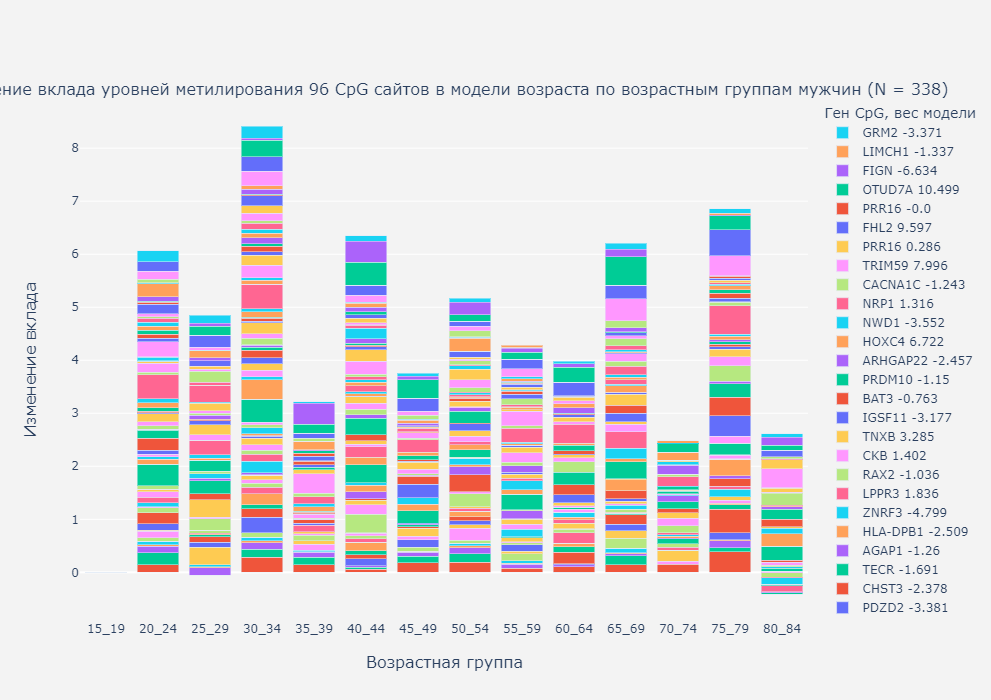

In [ ]:
fig = make_subplots(1,1,
                    subplot_titles = ['Изменение вклада уровней метилирования 96 '/
                                      +'CpG сайтов в модели возраста по возрастным'/
                                      +' группам мужчин (N = 338)'],
                    x_title= 'Возрастная группа',
                    y_title= 'Изменение вклада'
                   )
#genes = list(abs(sites_male_influence_diff['30_34']).sort_values(ascending=False).index[:20])

genes = sites_male_influence_diff.index

data = sites_male_influence_diff.loc[genes, :]

for site in data.index:
    
    gene = coefs_male.loc[site, 'Most_Common_Gene']
    
    koef = str(round(coefs_male.query('index == @site')[0].values[0], 3))

    fig.add_trace(go.Bar(
        name = gene+ ' ' + koef,
        x = data.columns,
        y = data.loc[site, :],
        #base = 'relative'
    )
        )

fig.update_layout(barmode='stack')

fig.update_layout(
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    height = 700,
    width = 1500,
    legend = dict( title = 'Ген CpG, вес модели')
    

)
fig.write_html(path_main_dir + '/visualizations/male_genes_influence_to_age_bar.html')
fig.show()

In [ ]:
fig = ff.create_dendrogram(sites_male_influence_share,
                          orientation = 'right',
                          labels = coefs_male['Most_Common_Gene'])

clustered_genes = pd.DataFrame({'Most_Common_Gene' : fig['layout']['yaxis']['ticktext'],
                               'sort' : fig['layout']['yaxis']['tickvals']}
                              )

coefs_male_clustered = clustered_genes.set_index('Most_Common_Gene').join(coefs_male.reset_index().set_index('Most_Common_Gene'))

coefs_male_clustered = coefs_male_clustered.reset_index()\
                        .set_index('index', drop = True)\
                        .sort_values(by = 'sort')

coefs_male_clustered

ValueError: Dimensions of Z and labels must be consistent.

In [ ]:
sites_male_influence_diff = sites_male_influence_diff.drop(['Most_Common_Gene','sort',0], axis = 1)

sites_male_influence_diff = sites_male_influence_diff.join(coefs_male_clustered).sort_values(by = 'sort')

sites_male_influence_diff = sites_male_influence_diff.drop(['Most_Common_Gene','sort',0], axis = 1)

,15_19,20_24,25_29,30_34,35_39,40_44,45_49,50_54,55_59,60_64,65_69,70_74,75_79,80_84
cg14110168,0.0,-0.054271,0.213669,0.075665,-0.451450,0.348180,-0.249158,0.239197,-0.173177,0.080978,-0.046793,0.131000,-0.008232,0.086223
cg13829625,0.0,-0.000249,0.000479,0.187594,-0.322004,0.217649,-0.162804,0.280397,-0.209166,0.076735,-0.028559,-0.012466,-0.103413,0.215681
cg13059495,0.0,0.149369,-0.049078,0.054272,-0.041184,0.318823,-0.070113,0.231889,-0.239174,0.252839,0.013163,0.005366,0.260164,0.184195
cg02228185,0.0,0.059430,0.039164,0.123862,0.019635,0.108094,0.033441,0.005092,0.067334,0.204928,-0.123151,-0.023076,0.296171,0.252530
cg02228185,0.0,0.059430,0.039164,0.123862,0.019635,0.108094,0.033441,0.005092,0.067334,0.204928,-0.123151,-0.023076,0.296171,0.252530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cg24079702,0.0,0.199537,0.102586,0.160713,0.080162,0.079129,0.167835,0.109968,0.022525,0.219221,0.177904,-0.065012,0.439163,-0.010517
cg06639320,0.0,0.219488,0.231437,0.267735,0.086903,0.185241,0.244857,0.093702,0.178764,0.256346,0.255295,-0.063908,0.492494,0.121866
cg24079702,0.0,0.199537,0.102586,0.160713,0.080162,0.079129,0.167835,0.109968,0.022525,0.219221,0.177904,-0.065012,0.439163,-0.010517
cg24652615,0.0,0.004571,-0.029362,0.026812,0.023701,0.126952,0.002045,0.033905,-0.002562,0.049075,0.220581,-0.240727,0.338165,-0.052420


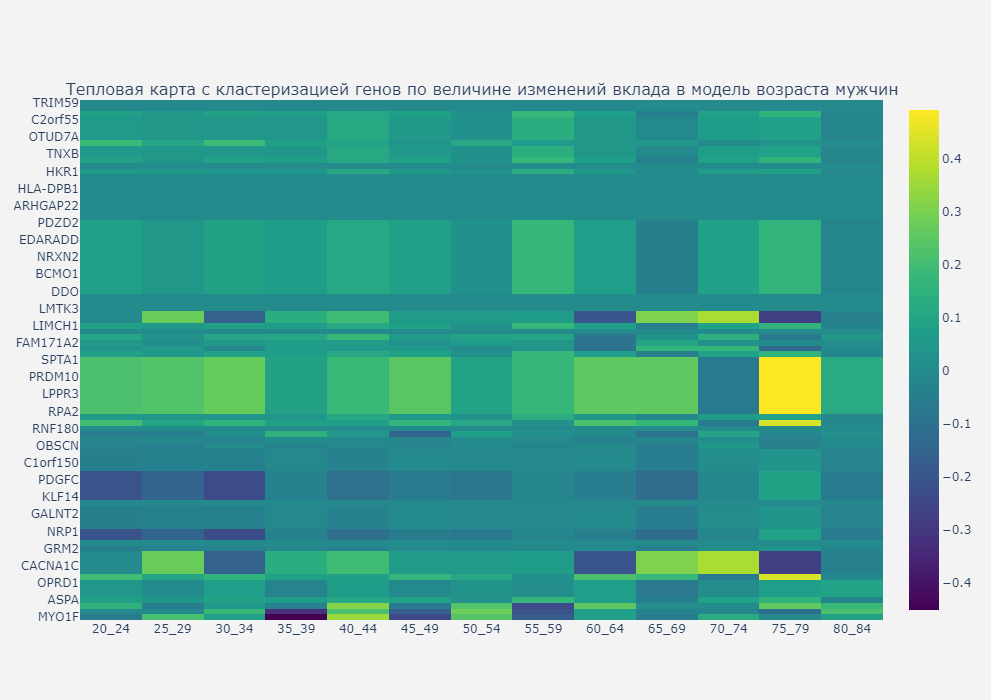

In [ ]:
genes = sites_male_influence_diff.index

sites_male_influence_diff\
            .loc[genes, :]

fig = make_subplots(1,1,
                    subplot_titles = ['Тепловая карта c кластеризацией генов по величине изменений вклада в модель возраста мужчин']
                   )

fig.add_trace(go.Heatmap(
    z = sites_male_influence_share_diff\
            .loc[genes, '20_24':].values,
    x = sites_male_influence_share_diff\
            .loc[genes, '20_24':].columns,
    y = coefs_male_clustered\
            .loc[genes, 'Most_Common_Gene'],
    colorscale='Viridis'
))

fig.update_layout(
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    height = 700,
    width = 1500,
    legend = dict( title = 'Величина изменения')
    )
fig.write_html(path_main_dir + '/visualizations/male_genes_influence_to_age_heat.html')
fig.show()

In [ ]:
coefs_male_clustered

,Most_Common_Gene,sort,0
index,,,
cg14110168,MYO1F,5,3.317675
cg13829625,SIN3B,15,-2.304658
cg13059495,TPRG1L,25,-6.655538
cg12317815,ASPA,35,-1.234306
cg02228185,ASPA,35,-4.790737
...,...,...,...
cg06639320,FHL2,1035,9.596544
cg22454769,FHL2,1035,9.832092
cg24079702,FHL2,1035,6.221950


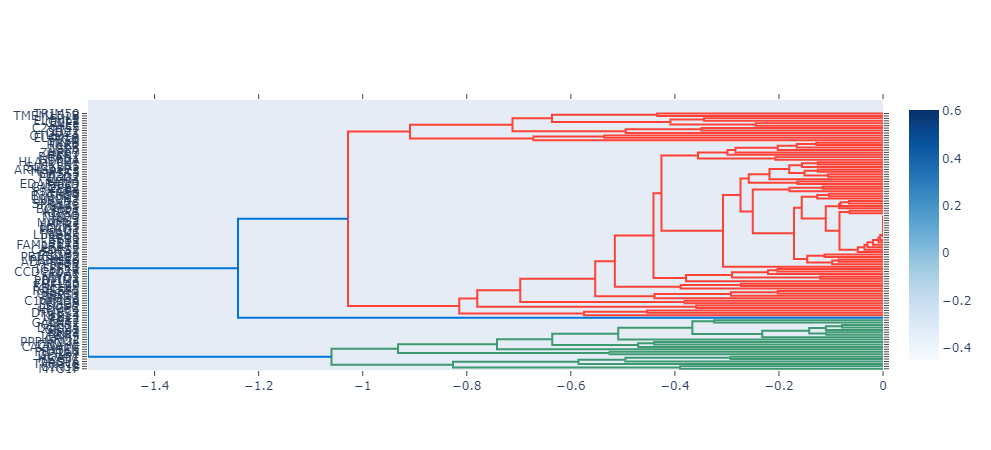

In [ ]:
fig.show()